# DRILL: Random Forest, Third Attempt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

df = pd.read_csv('https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1', skipinitialspace=True, header=1)
df.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [2]:
print(df.shape)
df = df[300000:]

df.shape

(421097, 111)


(121097, 111)

## First Attempt

In [3]:
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i, column.nunique())

id 121097
term 2
int_rate 60
grade 7
sub_grade 35
emp_title 44171
emp_length 11
home_ownership 3
verification_status 3
issue_d 5
loan_status 7
pymnt_plan 1
url 121095
desc 20
purpose 14
title 25
zip_code 851
addr_state 46
earliest_cr_line 617
revol_util 1128
initial_list_status 2
last_pymnt_d 25
next_pymnt_d 4
last_credit_pull_d 26
application_type 1
verification_status_joint 0


In [4]:
# Convert ID and Interest Rate to numeric.
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df['int_rate'] = pd.to_numeric(df['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
df.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [5]:
df.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df[:-2]
df.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421090,36371250.0,39102635.0,10000.0,10000.0,10000.0,36 months,11.99,332.10,B,8 years,...,0.0,1.0,100.0,100.0,0.0,0.0,32950.0,25274.0,9200.0,15850.0
421091,36441262.0,39152692.0,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,10+ years,...,0.0,2.0,56.5,100.0,0.0,0.0,152650.0,8621.0,9000.0,0.0
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0


## Second Attempt

In [7]:
rfc = ensemble.RandomForestClassifier()
X = df.drop('loan_status', 1)
Y = df['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.98150594, 0.98142338, 0.98200132, 0.98134082, 0.9820824 ,
       0.98034682, 0.98257351, 0.98224021, 0.9819098 , 0.98091855])

## Third Attempt

Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

In [8]:
print(df.columns)
df = df.drop('id', 1)
df = df.drop('member_id', 1)

df.head()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'emp_length',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=103)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
300000,15000.0,15000.0,15000.0,60 months,17.86,379.76,D,7 years,RENT,108150.0,...,0.0,3.0,100.0,50.0,0.0,0.0,109211.0,72757.0,15000.0,93028.0
300001,10850.0,10850.0,10850.0,36 months,10.99,355.17,B,7 years,MORTGAGE,56000.0,...,0.0,0.0,95.2,28.6,0.0,0.0,341790.0,30385.0,60500.0,0.0
300002,16000.0,16000.0,16000.0,36 months,15.61,559.44,D,2 years,RENT,50000.0,...,0.0,8.0,97.6,44.4,0.0,0.0,82349.0,62033.0,27600.0,44149.0
300003,10000.0,10000.0,10000.0,36 months,6.92,308.41,A,< 1 year,MORTGAGE,48500.0,...,0.0,2.0,100.0,40.0,0.0,0.0,240138.0,47253.0,14000.0,37363.0
300004,14000.0,14000.0,14000.0,60 months,9.17,291.78,B,4 years,RENT,90000.0,...,0.0,4.0,100.0,0.0,0.0,0.0,316452.0,72655.0,36800.0,78448.0


In [9]:
df.dtypes

loan_amnt                         float64
funded_amnt                       float64
funded_amnt_inv                   float64
term                               object
int_rate                          float64
installment                       float64
grade                              object
emp_length                         object
home_ownership                     object
annual_inc                        float64
verification_status                object
issue_d                            object
loan_status                        object
pymnt_plan                         object
purpose                            object
title                              object
dti                               float64
delinq_2yrs                       float64
inq_last_6mths                    float64
mths_since_last_delinq            float64
mths_since_last_record            float64
open_acc                          float64
pub_rec                           float64
revol_bal                         

In [10]:
# Make term number
df.term = df.term.map({' 60 months': 60, ' 36 months': 36})

# Make emp_length number
df['emp_length'] = df['emp_length'].str.extract('(\d+)')
df = df.dropna(subset=['emp_length'])
df['emp_length'] = df['emp_length'].astype(int)

# Make grade, issue_d, last_pymnt_d, next_pymnt_d, last_credit_pull_d a string
df['grade'] = df['grade'].astype(str)
df.issue_d = df.issue_d.astype(str)
df.last_pymnt_d = df.last_pymnt_d.astype(str)
df = df.dropna(subset=['next_pymnt_d'])
df.next_pymnt_d = df.next_pymnt_d.astype(str)
df = df.dropna(subset=['last_credit_pull_d'])
df.next_pymnt_d = df.last_credit_pull_d.astype(str)

# Make verification_status a boolean (dummies?)
df.verification_status = df.verification_status.map({'Source Verified': 1, 'Not Verified': 0, 'Verified': 1})

# Drop pymnt_plan and application_type and verification_status_joint (only 1 value each) and title (purely qualitative and inconsistent)
df = df.drop('pymnt_plan', 1)
df = df.drop('application_type', 1)
df = df.drop('verification_status_joint', 1)
df = df.drop('title', 1)

# Make home_ownership, purpose, loan_status, initial_list_status into dummies later?

In [11]:
dtype_groups = df.columns.to_series().groupby(df.dtypes).groups
dtype_dict = {k.name: v for k, v in dtype_groups.items()}
all_num_cols = list(dtype_dict['float64']) + list(dtype_dict['int64']) + ['loan_status']

df = df[all_num_cols]
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,term,emp_length,verification_status,loan_status
300000,15000.0,15000.0,15000.0,17.86,379.76,108150.0,28.25,1.0,0.0,16.0,...,0.0,0.0,109211.0,72757.0,15000.0,93028.0,60,7,1,Current
300001,10850.0,10850.0,10850.0,10.99,355.17,56000.0,12.92,0.0,0.0,27.0,...,0.0,0.0,341790.0,30385.0,60500.0,0.0,36,7,0,Current
300002,16000.0,16000.0,16000.0,15.61,559.44,50000.0,14.28,0.0,0.0,62.0,...,0.0,0.0,82349.0,62033.0,27600.0,44149.0,36,2,1,Current
300004,14000.0,14000.0,14000.0,9.17,291.78,90000.0,29.33,0.0,0.0,NaN,...,0.0,0.0,316452.0,72655.0,36800.0,78448.0,60,4,1,Current
300005,33500.0,33500.0,33500.0,9.17,698.18,180000.0,19.54,0.0,0.0,NaN,...,0.0,0.0,417089.0,127581.0,49000.0,113891.0,60,2,1,Current


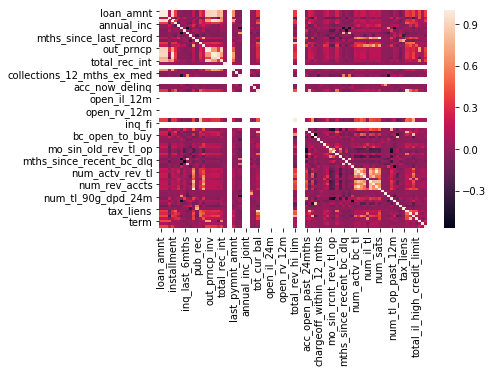

In [12]:
sns.heatmap(df.corr())
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca_num_components = [10, 3, 2, 1]

def get_pca_cross_val_score(num_components):
    X = df.drop('loan_status', 1)
    X = pd.get_dummies(X)
    old_num_cols = len(X.columns)
    X = X.dropna(axis=1)
    print('Dropped', len(X.columns) - old_num_cols, 'columns')
    
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(X)
    
    rfc = ensemble.RandomForestClassifier()
    Y = df['loan_status']
    X = principal_components
    
    print(num_components, cross_val_score(rfc, X, Y, cv=10))

for num_components in pca_num_components:
    get_pca_cross_val_score(num_components)

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

I can do this without anything related to payment amount or outstanding principal – I ran PCA again without those columns, and got extremely similar cross validation scores for the same number of components.

In [15]:
def get_pca_cross_val_score_wo_pymnt_or_principal(num_components):
    X = df.drop('loan_status', 1)
    X = X.drop('total_pymnt', 1)
    X = X.drop('out_prncp', 1)
    X = X.drop('total_pymnt_inv', 1)
    X = X.drop('out_prncp_inv', 1)
    X = pd.get_dummies(X)
    old_num_cols = len(X.columns)
    X = X.dropna(axis=1)
    print('Dropped', len(X.columns) - old_num_cols, 'columns')
    
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(X)
    
    rfc = ensemble.RandomForestClassifier()
    Y = df['loan_status']
    X = principal_components
    
    print(num_components, cross_val_score(rfc, X, Y, cv=10))

for num_components in pca_num_components:
    get_pca_cross_val_score(num_components)

10 [0.94280955 0.94267074 0.94280955 0.94294044 0.94294044 0.94307927
 0.94307927 0.94306346 0.94333333 0.94291667]
3 [0.9422543  0.94239311 0.9422543  0.94155213 0.94113564 0.94238512
 0.94266278 0.94236912 0.94194444 0.94305556]
2 [0.93906163 0.94058856 0.93947807 0.93905317 0.9396085  0.94127447
 0.93974733 0.93945285 0.94069444 0.93944444]
1 [0.90283176 0.89825097 0.90310938 0.90254061 0.90351243 0.90351243
 0.9011523  0.90848493 0.90194444 0.90333333]


It seems like 2 is the minimum number of components needed for PCA to still get > 90% cross validation scores across 10 folds. 

In [ ]:
# FEEDBACK NOTES:

# REMINDER: correlation matrices do not work for categorical (so no point in doing these correlation matrices)
# May just show that I need to do PCA to get rid of unnecessary features that are highly correlated with others

# you CAN test for multicollinearity, but doesn't matter for random forest
# random forest is NOT affected by multicollinearity 
# (will simply vote for whatever the 2 correlated features say target should be)

# To test effectiveness on categorical target:

# T test will help you see:
# - distribution of data for different categories is significantly different? T-test
# - difference in categories' averages? (using standard deviation as well)

# effective of category on category - chi square (REVIEW)
# effect of category on continuous - t-test / z-test

# random forest (ensemble model) – each decision tree votes on response / target